In [1]:
import numpy as np
import scipy
import scipy.spatial
from scipy.spatial.distance import squareform,pdist,cdist
import matplotlib.pyplot as plt
from scipy.io import mmread

from sklearn.manifold import TSNE
from joblib import Parallel, delayed

from timeit import default_timer as timer

import scanpy as sc
import anndata as ad


from scipy.sparse import csr_matrix
import pandas as pd
import anndata as ad


In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))


# Experimnet

### Load data 

In [4]:
# df_meta : E14_5 WLS CTL meta data
# df : E14_5 WLS CTL raw data

In [8]:
cell_types= np.array(df_meta['celltype'].values)
phase_types= np.array(df_meta['Phase'].values)

In [9]:
print(np.unique(cell_types))
print(np.unique(phase_types))

['DC' 'LD' 'UD']
['G1' 'G2M' 'S']


In [ ]:
x_orig= df.values.T[1:]
gene_names_orig=  df.values.T[0]

# Preprocess data

In [10]:
x_adata = ad.AnnData(x_orig+0.)
sc.pp.normalize_total(x_adata,target_sum=1e6)
sc.pp.log1p(x_adata)
sc.pp.highly_variable_genes(x_adata,n_top_genes=10000)
sc.pp.scale(x_adata)


In [11]:
x = x_adata.X[:,np.where(x_adata.var['highly_variable'])[0]]+0.
gene_names = gene_names_orig[x_adata.var['highly_variable'].index.to_numpy()[np.where(x_adata.var['highly_variable'])].astype(int)]

x.shape

(5598, 10000)

In [12]:
from collections import Counter
print(Counter(cell_types))
print(Counter(phase_types))


Counter({'UD': 3517, 'LD': 1732, 'DC': 349})
Counter({'G1': 2765, 'G2M': 1428, 'S': 1405})


# Experiments

In [15]:
from FP import *

In [17]:
x_SVD = SVD_mean_shifted( x,500)
x_new_SVD= (x_SVD[0][::,:50], x_SVD[1][:50], x_SVD[2][:50,:])

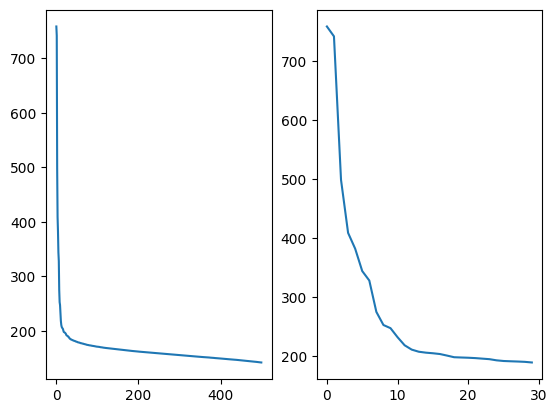

In [18]:
f,ax= plt.subplots(1,2)
ax[0].plot(x_SVD[1])
ax[1].plot(x_SVD[1][:30])

# run algorithm

In [22]:
K=2
perplexity=40

verbose_updates= True


FP_K2 = FP(K=K, perplexity=perplexity)


In [ ]:
FP_K2.fit(x_new_SVD, verbose_updates= verbose_updates, simulations=100)


Begin sim 0
Current delta = 0.05233930665684734  amount 1/2 10000 amount 01   0
Current delta = 0.05233930665684734  amount 1/2 10000 amount 01   0
Current delta = 0.02616965332842367  amount 1/2 10000 amount 01   0
Current delta = 0.013084826664211836  amount 1/2 9997 amount 01   0
Current delta = 0.013084826664211836  amount 1/2 9992 amount 01   8
Current delta = 0.013084826664211836  amount 1/2 9988 amount 01   9
Current delta = 0.013084826664211836  amount 1/2 9980 amount 01   10
Current delta = 0.013084826664211836  amount 1/2 9887 amount 01   31
Current delta = 0.013084826664211836  amount 1/2 9785 amount 01   129
Current delta = 0.013084826664211836  amount 1/2 9701 amount 01   211
Current delta = 0.013084826664211836  amount 1/2 9581 amount 01   252
Current delta = 0.013084826664211836  amount 1/2 9506 amount 01   275
Current delta = 0.013084826664211836  amount 1/2 9460 amount 01   302
Current delta = 0.006542413332105918  amount 1/2 8910 amount 01   587
Current delta = 0.0065

# Visualization

In [ ]:
feat_partitions = FP_K2.get_feature_partitions()

In [43]:
emb_all = TSNE(n_components=3, perplexity=40, random_state=42).fit_transform(x_new_SVD[0]*x_new_SVD[1])
emb_ours = [ TSNE(n_components=3, perplexity=40, random_state=42).fit_transform((x_new_SVD[0]*x_new_SVD[1])@x_new_SVD[2][:, feat_partitions[i]>0.5]) for i in range(K)]


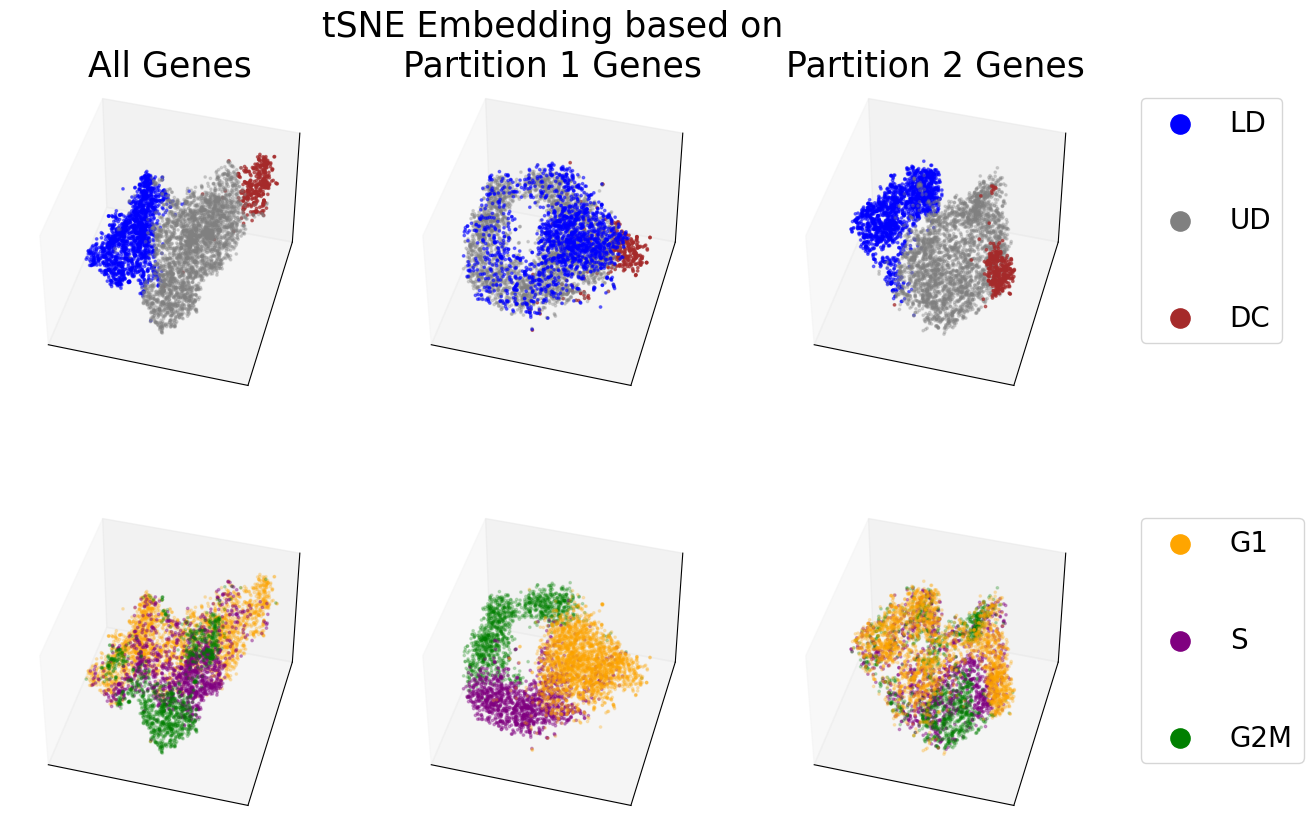

In [44]:
colors1= ['blue','grey','brown']
colors2= ['orange','purple','green']
alpha=0.1
s=3
f,ax= plt.subplots(2,3,figsize=(14,10),subplot_kw={'projection':'3d'})
for i,l in enumerate(['LD','UD','DC']):
    alpha=[0.7,0.4,0.9][i]*0.7

    inds= np.where(np.array(cell_types)==l)[0]
    ax[0,0].scatter(emb_all[inds,0], emb_all[inds,1], emb_all[inds,2],label=l,alpha=alpha,s=s,c=colors1[i])
    ax[0,1].scatter(emb_ours[0][inds,0], emb_ours[0][inds,1], emb_ours[0][inds,2],label=l,alpha=alpha,s=s,c=colors1[i])
    ax[0,2].scatter(emb_ours[1][inds,0], emb_ours[1][inds,1], emb_ours[1][inds,2],label=l,alpha=alpha,s=s,c=colors1[i])

#for i,l in enumerate(np.unique(phase_types)):
for i,l in enumerate(['G1','S','G2M']):
    alpha=[0.3,0.5,0.3][i]*0.7

    inds= np.where(np.array(phase_types)==l)[0]
    ax[1,0].scatter(emb_all[inds,0], emb_all[inds,1], emb_all[inds,2],label=l,alpha=alpha,s=s,c=colors2[i])
    ax[1,1].scatter(emb_ours[0][inds,0], emb_ours[0][inds,1], emb_ours[0][inds,2],label=l,alpha=alpha,s=s,c=colors2[i])
    ax[1,2].scatter(emb_ours[1][inds,0], emb_ours[1][inds,1], emb_ours[1][inds,2],label=l,alpha=alpha,s=s,c=colors2[i])

l1= ax[0,2].legend(markerscale=8,loc='upper left', bbox_to_anchor=(1.1, 1),fontsize=20,labelspacing=2.5)
l2= ax[1,2].legend(markerscale=8,loc='upper left', bbox_to_anchor=(1.1, 1),fontsize=20,labelspacing=2.5)

for lh in l1.legend_handles: 
    lh.set_alpha(1)
for lh in l2.legend_handles: 
    lh.set_alpha(1)

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
    a.set_zticks([])


ax[0,0].set_title('All Genes',fontsize=25)
ax[0,1].set_title('tSNE Embedding based on\nPartition 1 Genes',fontsize=25)
ax[0,2].set_title('Partition 2 Genes',fontsize=25)

ax[0,0].view_init(45,105)
ax[1,0].view_init(45,105)

ax[0,2].view_init(45,105)
ax[1,2].view_init(45,105)
ax[0,1].view_init(45,105)
ax[1,1].view_init(45,105)

# Genes Analysis

In [34]:
wanted_genes= np.array([np.where(gene_names =='Foxd1' ),\
                       np.where(gene_names =='Sox2' ),\
                       np.where(gene_names =='Mki67' ),\
                       np.where(gene_names =='Ccna2' ),\
                       np.where(gene_names =='Ptch1' ),\
                       np.where(gene_names =='Lef1' )]).flatten()
wanted_genes
for i in wanted_genes:
    for j in range(K):
        if (FP_K2.best_omega[j][i]>0.5):
            print(j) 

1
1
0
0
1
1


In [35]:
from scipy.spatial.distance import pdist,squareform
def LaplacianScore(W,x, isZscored=True):
    if not isZscored:
        return np.mean(np.sum(W+W.T,axis=1,keepdims=True)*x**2,axis=0) -2* np.mean((W@x)*x,axis=0)   
    
    newX= (x-np.mean(x,axis=0,keepdims=True))/(1e-10+ np.std(x,axis=0,keepdims=True))
    
    
    res= np.mean(np.sum(W+W.T,axis=1,keepdims=True)*newX**2,axis=0) -2* np.mean((W@newX)*newX,axis=0)
    res[np.where(np.std(x,axis=0)<1e-10)[0]]=1e10
    return res

In [36]:
cur_gene_indes =[]
score_genes = []

for i in range(K):

    cur_scores= LaplacianScore(FP_K2.get_affinity_matrices()[i], (x_new_SVD[0]*x_new_SVD[1])@x_new_SVD[2][:, omega[i]>0.5], isZscored=True)
    cur_genes=  np.where(omega[i]>0.5)[0][np.argsort(cur_scores)]
    cur_scores= np.sort(cur_scores)

    cur_gene_indes.append( cur_genes+0)
    score_genes.append( cur_scores+0)

In [37]:
for i in range(K):
    print(np.array(gene_names)[cur_gene_indes[i][:40]])

['Ckap2l' 'Cenpf' 'Ccna2' 'Top2a' 'Ube2c' 'Kif22' 'Hmmr' 'Prc1' 'Ndc80'
 'Tpx2' 'Nusap1' 'Cdca8' 'Incenp' 'Shcbp1' 'Knl1' 'Sgo2a' 'Spc25' 'Ccnb1'
 'Kif23' 'Cenpe' 'Racgap1' 'Ncapg' 'Mxd3' 'Melk' 'Kif20b' 'Ska1' 'Dbf4'
 'Aurkb' 'Mki67' 'Bub1' 'Smc4' 'Kif15' 'Cdca3' 'Pbk' 'Tacc3' 'Mis18bp1'
 'Cenpq' 'Kif11' 'Sgo1' 'Spdl1']
['Nrk' 'Itm2a' 'Agtr2' 'Akap12' 'Plagl1' 'Abi3bp' 'Igf2' 'Ptn' 'Rbp1'
 'Igfbp4' 'Crabp1' 'Dpt' 'Tmeff2' 'Loxl1' 'Creb5' 'Cdkn1c' 'Rarres2' 'H19'
 'Bcl11b' 'Lix1' 'Tshz2' 'Postn' 'Fibin' 'Sfrp2' 'Dmrt2' 'Thbs2' 'Zeb2'
 'Zfhx4' 'Nfib' 'Man2a1' 'Sema3c' 'Angptl1' 'Emp2' 'Dlk1' 'Col7a1' 'Rtl3'
 'Lox' 'Cavin2' 'Dkk2' 'Klf4']


## Compare with Seurat cell-cycle genes

In [38]:
# Seurat's cell-cycle genes were extracted from R using the following R code:
# 
# library(Seurat)
# library(gprofiler2)
#
# genes_s = gorth(cc.genes.updated.2019$s.genes, source_organism = "hsapiens", target_organism = "mmusculus")$ortholog_name 
# genes_g2m = gorth(cc.genes.updated.2019$g2m.genes, source_organism = "hsapiens", target_organism = "mmusculus")$ortholog_name 
# genes_c = c(genes_s,genes_g2m)
# cat(paste(shQuote(genes_c), collapse = ","))

CC_genes= ['Mcm5','Pcna','Tyms','Fen1','Mcm7','Mcm4','Rrm1','Ung','Gins2','Mcm6','Cdca7','Dtl','Prim1','Uhrf1','Cenpu','Hells','Rfc2','Polr1b','Nasp','Rad51ap1','Gmnn','Wdr76','Slbp','Ccne2','Ubr7','Msh2','Rad51','Rrm2','Cdc45','Cdc6','Exo1','Tipin','Dscc1','Blm','Casp8ap2','Usp1','Clspn','Pola1','Chaf1b','Mrpl36','E2f8','Hmgb2','Cdk1','Nusap1','Ube2c','Birc5','Tpx2','Top2a','Ndc80','Cks2','Nuf2','Cks1b','Mki67','Tmpo','Cenpf','Tacc3','Pimreg','Smc4','Ccnb2','Ckap2l','Ckap2','Aurkb','Bub1','Kif11','Anp32e','Tubb4b','Gtse1','Kif20b','Hjurp','Cdca3','Jpt1','Cdc20','Ttk','Cdc25c','Kif2c','Rangap1','Ncapd2','Dlgap5','Cdca2','Cdca8','Ect2','Kif23','Hmmr','Aurka','Psrc1','Anln','Lbr','Ckap5','Cenpe','Ctcf','Nek2','G2e3','Gas2l3','Cbx5','Cenpa']

print('Number of Seurat CC phase Genes :'+str(len(CC_genes)))
print('Number of Seurat CC phase Genes after the preprocessing :'+str(len([a for a in CC_genes if a in gene_names])))
print('Number of Seurat CC phase Genes after the preprocessing within partition 1 :'+str(len([a for a in CC_genes if a in gene_names[feat_partitions[0]]])))
print()

Number of Seurat CC phase Genes :95
Number of Seurat CC phase Genes after the preprocessing :81
Number of Seurat CC phase Genes after the preprocessing within partition 1 :81

